In [24]:
from langgraph.graph import StateGraph, START , END
from dotenv import load_dotenv
load_dotenv()
from langchain_core.prompts import ChatPromptTemplate
from typing import TypedDict,Optional, Annotated,List
from  langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from  langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder
from  langchain_core.messages import HumanMessage,AIMessage, BaseMessage
from langgraph.checkpoint.memory import MemorySaver

In [25]:
from langgraph.graph import add_messages
class Messages_State(TypedDict):
    message_history : Annotated[List[BaseMessage],add_messages]

     

In [26]:
llm = HuggingFaceEndpoint(model="meta-llama/Meta-Llama-3-8B-Instruct",task="text-generation")
model = ChatHuggingFace(llm=llm)

In [27]:
def chatBot(state:Messages_State):
    message = state['message_history'][-1]
    template = ChatPromptTemplate.from_messages([
        ("system", "You are a teacher. Answer the question asked by student."),
       MessagesPlaceholder(variable_name="chat_history"), ("human", "{message}")
    ])

    prompt = template.invoke({'message':message.content, 'chat_history':state['message_history'][:-1]})

    result = model.invoke(prompt)

    return {
    "message_history": [result]
}


In [28]:
graph = StateGraph(Messages_State)

In [29]:
checkpointer = MemorySaver()


graph.add_node("chatBot",chatBot)
graph.add_edge(START,'chatBot')
graph.add_edge('chatBot',END)

In [30]:
workflow = graph.compile(checkpointer=checkpointer)

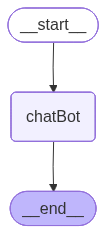

In [31]:
workflow

In [ ]:
thread_id = '1'
while True:
    user_query_input = input("Enter your query: \n")
    if user_query_input == "-1":
        break

    user_query = HumanMessage(content=user_query_input)
    print('Human: ', user_query.content)

    config = {'configurable': {'thread_id': thread_id}}
        
    for msg in workflow.stream(
        {'message_history': [user_query]},
        config=config,
        stream_mode='values' 
    ):
     
        last_message = msg['message_history'][-1]
        if isinstance(last_message, AIMessage):
            print("Teacher:", last_message.content)

        

Human:  hello
Teacher: Hello there! It's great to see you in class today. Do you have any questions or would you like to start with something specific?
Human:  my name is priy
Teacher: Nice to meet you, Priy. Now that we've introduced ourselves, let's get started with our lesson. What topic are we covering today?
Human:  what is 2+2
Teacher: A simple yet fundamental math question, Priy. The answer to 2 + 2 is 4.
Human:  what is math
Teacher: Math is a way of using numbers, patterns, and problem-solving techniques to understand and describe the world around us. It's a powerful tool that helps us measure, calculate, and make sense of the physical and numerical world.

Math involves numbers, shapes, algebra, geometry, and more, and it's used in many different fields, such as science, engineering, finance, and even art.

In simpler terms, math is like a language that helps us solve problems and understand how things work.

Would you like to learn more about a specific area of math, Priy?
H

In [33]:
workflow.get_state(config=config)

StateSnapshot(values={'message_history': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='0318168a-37b7-43f9-9589-c5d43df00799'), AIMessage(content="Hello there! It's great to see you in class today. Do you have any questions or would you like to start with something specific?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 48, 'total_tokens': 77}, 'model_name': 'meta-llama/Meta-Llama-3-8B-Instruct', 'system_fingerprint': '', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019beea9-c008-7ad3-924f-c7254dc875b1-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 48, 'output_tokens': 29, 'total_tokens': 77}), HumanMessage(content='my name is priy', additional_kwargs={}, response_metadata={}, id='41a62e27-ace1-45d0-bce0-feeb4b6c7007'), AIMessage(content="Nice to meet you, Priy. Now that we've introduced ourselves, let's get started with our lesson. What topic are we covering tod

In [34]:
# result['message_history']